In [3]:
from pylab import *
from numpy.linalg import norm
import pymc

%matplotlib inline

In [4]:
def get_SI(name):
    phys_constants = {
    'aEarthSun': 1.5 * 10**11, # meters
    'eEarth': 0.06, 
    'mEarth': 5.97 * 10**24, # kg
    'mSun': 1.99 * 10**30, # kg	
    'G': 6.67 * 10**-11
    }
    return phys_constants[name]

def gen_ellipse_X(a, e, phi_array):
    b = a * np.sqrt(1 - e**2)
    X = np.zeros([len(phi_array), 3]) # 3 dimensions, but the z will all be 0 for orbit in the plane.
    X[:,0] = a * np.cos(phi_array) +  a * e
    X[:,1] = b * np.sin(phi_array)
    return X

def gen_ellipse_V_dir(a, e, phi_array):
    b = a * np.sqrt(1 - e**2)
    nRows = 1 if type(phi_array)==float else len(phi_array)
    V_dir = np.zeros([nRows, 3])
    V_dir[:,0] = -a * np.sin(phi_array)
    V_dir[:,1] = b * np.cos(phi_array)
    normalization_vec = 1/norm(V_dir, axis=1)
    V_dir = (V_dir.T * normalization_vec).T
    return V_dir

def orbital_speed(r, a, m1, m2):
    mu = m1 * m2 /(m1 + m2)
    G = 6.67 * 10**-11
    return np.sqrt(G * (m1 + m2) * (2/r - 1/a))
orbital_speed = np.vectorize(orbital_speed)

def gen_V_vec(phi_array, a, e, m1, m2):
    V_dir = gen_ellipse_V_dir(a, e, phi_array)
    speeds = orbital_speed(norm(X, axis=1), a=a, m1=m1, m2=m2)
    return (V_dir.T * speeds).T


def is_orbit_bound(m1, m2, X, V):
    speed = np.linalg.norm(V)
    mu = m1 * m2 / (m1 + m2)
    KE = 0.5 * mu * speed**2
    
    G = 6.67e-11
    r = np.linalg.norm(X)
    U = -(G * m1 * m2) / r
    
    return KE + U < 0
is_orbit_bound = np.vectorize(is_orbit_bound)

# given bodies m and M with relative position and velocity r_vec and v_vec,
# return the semi-major axis and eccentricity of this orbit. 
def NewAE(m, M, r_vec, v_vec):
    mu = (m * M) / (m + M)												# reduced mass.
    E = - ((G * m * M) / np.linalg.norm(r_vec) + (0.5) *	# energy. 
        mu * np.linalg.linalg.dot(v_vec, v_vec))
    a = - (G * m * M) / (2 * E)				# semi-major axis.
    J = mu * np.cross(r_vec, v_vec)		# angular momentum.
    e = np.sqrt(1 - (np.linalg.norm(J)**2)/(mu**2 * (m + M) * G * a)) # eccentricity
    return a, e



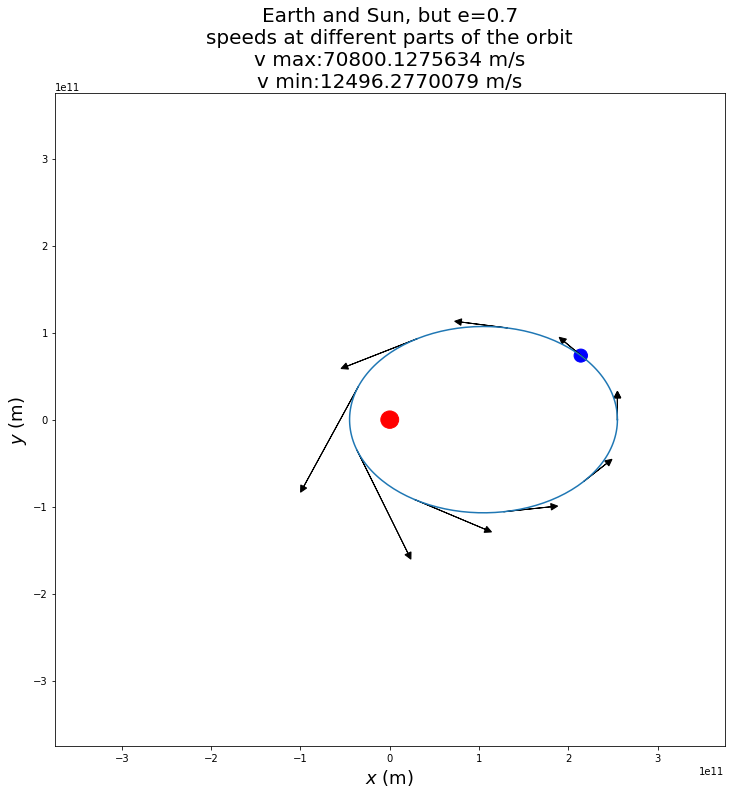

In [7]:
# For a basic test, plot the velocities at several points around an orbit. 

phi_1rev = np.linspace(0, 2*np.pi, 200)
a, e = get_SI('aEarthSun'), 0.7 
X = gen_ellipse_X(a, e, phi_1rev)
V_dir = gen_ellipse_V_dir(a, e, phi_1rev)
speeds = orbital_speed(norm(X, axis=1), a=a, m1=get_SI('mEarth'), m2=get_SI('mSun'))

fig1 = figure(figsize=(12, 12))
circle_star = Circle((0, 0), get_SI('aEarthSun')/15, color='r')
circle_planet = Circle((X.T[0][24], X.T[1][24]), get_SI('aEarthSun')/20, color='b')
ax = fig1.gca(); ax.add_artist(circle_star); ax.add_artist(circle_planet)
plot(X.T[0], X.T[1])
arrow_indices = np.linspace(0, len(V_dir)-1, 10).astype(int)
SC = 2e6 # scaling constant.
for i in arrow_indices:
    arrow(X.T[0][i], X.T[1][i], 
          SC * speeds[i] * V_dir.T[0][i], SC * speeds[i] * V_dir.T[1][i], 
          head_width=a / 20., head_length=a/20., fc='k', ec='k')

C = 2.5    
xlim([-a * C,a * C]), ylim([-a * C, a * C])
xlabel('$x$ (m)', fontsize=(18)); ylabel('$y$ (m)', fontsize=(18))
title('Earth and Sun, but e=0.7\nspeeds at different parts of the orbit\nv max:{} m/s\nv min:{} m/s'.format(
    speeds.max(), speeds.min()), 
      fontsize=20)
savefig('fig1')

#fig2 = figure(figsize=(6,6))
#plot( range(len(X)), norm(X, axis=1))
#title('r(t)')
#xlabel('time (non units)'); ylabel('r (meters)')


#fig3 = figure(figsize=(6,6))
#plot(range(len(X)), speeds)
#title('speed (m/s)'); ylabel('speed m/s'); xlabel('phase')



|v kick|:[   2347.29126057 -106174.24765675       0.        ]


/Users/aaron/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: divide by zero encountered in double_scalars


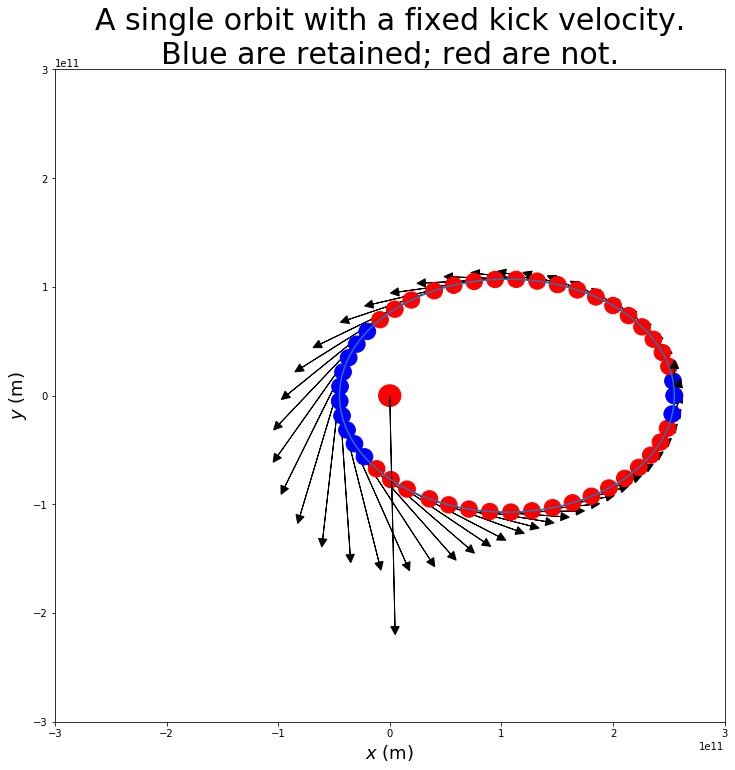

In [37]:
# Now, adding in kick velocity and marking where in the orbit the planet remains orbitally bound. 



phi_1rev = np.linspace(0, 2*np.pi, 200)
a, e = get_SI('aEarthSun'), 0.7 
X = gen_ellipse_X(a, e, phi_1rev)
V_dir = gen_ellipse_V_dir(a, e, phi_1rev)
speeds = orbital_speed(norm(X, axis=1), a=a, m1=get_SI('mEarth'), m2=get_SI('mSun'))
V_vec = gen_V_vec(phi_array=phi_1rev, a=a, e=e, m1=get_SI('mSun'), m2=get_SI('mEarth'))

# choose a kick velocity similar to an orbital speed
C = 1.5
V_kick = C * V_vec[int(len(V_vec)/2)]; print('|v kick|:{}'.format(V_kick))
new_V_vec = V_vec - np.ones([3, ])
is_orbit_bound_array = is_orbit_bound(m1=get_SI('mEarth'), m2=get_SI('mSun'), 
                      X=X, V=V_vec - V_kick).T[1]

fig1 = figure(figsize=(12, 12))

# actual orbit shape.
plot(X.T[0], X.T[1])

circle_star = Circle((0, 0), get_SI('aEarthSun')/15, color='r')
ax = fig1.gca(); ax.add_artist(circle_star); 
arrow_indices = np.linspace(0, len(V_dir)-1, 50).astype(int)
SC = 2e6 # scaling constant.
for i in arrow_indices:
    arrow(X.T[0][i], X.T[1][i], 
          SC * V_vec.T[0][i], SC * V_vec.T[1][i], 
          head_width=a / 20., head_length=a/20., fc='k', ec='k')
    if is_orbit_bound_array[i]:
        circle_planet = Circle((X.T[0][i], X.T[1][i]), get_SI('aEarthSun')/20, color='b')
        ax.add_artist(circle_planet)
    else:
        circle_planet = Circle((X.T[0][i], X.T[1][i]), get_SI('aEarthSun')/20, color='r')
        ax.add_artist(circle_planet)
# draw the kick velocity 
arrow(0, 0, SC * V_kick[0], SC * V_kick[1], 
      head_width=a / 20., head_length=a/20., fc='k', ec='k')

C = 2.0    
xlim([-a * C,a * C]), ylim([-a * C, a * C])
xlabel('$x$ (m)', fontsize=(18)); ylabel('$y$ (m)', fontsize=(18))
title('A single orbit with a fixed kick velocity.\nBlue are retained; red are not.'.format(
    speeds.max(), speeds.min()), 
      fontsize=30)
savefig('retentionillustration', dpi=300)

#fig2 = figure(figsize=(6,6))
#plot( range(len(X)), norm(X, axis=1))
#title('r(t)')
#xlabel('time (non units)'); ylabel('r (meters)')


#fig3 = figure(figsize=(6,6))
#plot(range(len(X)), speeds)
#title('speed (m/s)'); ylabel('speed m/s'); xlabel('phase')

In [22]:
is_orbit_bound_array

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,